In [9]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)#Table"

# Use headers to pretend we are a browser
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

# Fetch page
response = requests.get(url, headers=headers)
response.raise_for_status()

# Parse with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find the first table with class 'wikitable'
table = soup.find("table", {"class": "wikitable"})

# Convert to DataFrame
df = pd.read_html(str(table))[0]

print(df.head())
df.info()

  Country/Territory IMF (2025)[1][6] World Bank (2022–24)[7]  \
0             World        113795678               111326370   
1     United States         30507217                29184890   
2   China[n 1][n 3]         19231705                18743803   
3           Germany          4744804                 4659929   
4             India          4187017                 3912686   

  United Nations (2023)[8]  
0                100834796  
1                 27720700  
2                 17794782  
3                  4525704  
4                  3575778  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Country/Territory         222 non-null    object
 1   IMF (2025)[1][6]          222 non-null    object
 2   World Bank (2022–24)[7]   222 non-null    object
 3   United Nations (2023)[8]  222 non-null    object
dtypes: objec

/tmp/ipykernel_132/1120044934.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [10]:
df = df.rename(columns={"Country/Territory": "Country", "IMF (2025)[1][6]": "IMF", "World Bank (2022–24)[7]": "World Bank", "United Nations (2023)[8]": "United Nations"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country         222 non-null    object
 1   IMF             222 non-null    object
 2   World Bank      222 non-null    object
 3   United Nations  222 non-null    object
dtypes: object(4)
memory usage: 7.1+ KB


In [11]:
# clean and convert IMF, World Bank, United Nations to float64

for col in ["IMF", "World Bank", "United Nations"]:
    df[col] = (
        df[col]
        .astype(str)                        # make sure they're strings
        .str.replace(",", "", regex=False)  # remove commas
        .str.replace(" ", "", regex=False)  # remove spaces
        .str.replace("−", "-", regex=False) # fix special minus sign
        .str.replace("—", "", regex=False)  # replace em dash with empty
    )

    # convert to numeric (invalid strings become NaN)
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")

print(df.dtypes)

Country            object
IMF               float64
World Bank        float64
United Nations    float64
dtype: object


In [12]:
df.head()


,Country,IMF,World Bank,United Nations
0,World,113795678.0,111326370.0,100834796.0
1,United States,30507217.0,29184890.0,27720700.0
2,China[n 1][n 3],19231705.0,18743803.0,17794782.0
3,Germany,4744804.0,4659929.0,4525704.0
4,India,4187017.0,3912686.0,3575778.0


In [14]:
# calculate row-wise mean (ignoring NaN)
row_means = df[["IMF", "World Bank", "United Nations"]].mean(axis=1, skipna=True)

# fill NaN in each column with the row mean
for col in ["IMF", "World Bank", "United Nations"]:
    df[col] = df[col].fillna(row_means)
    df.loc[

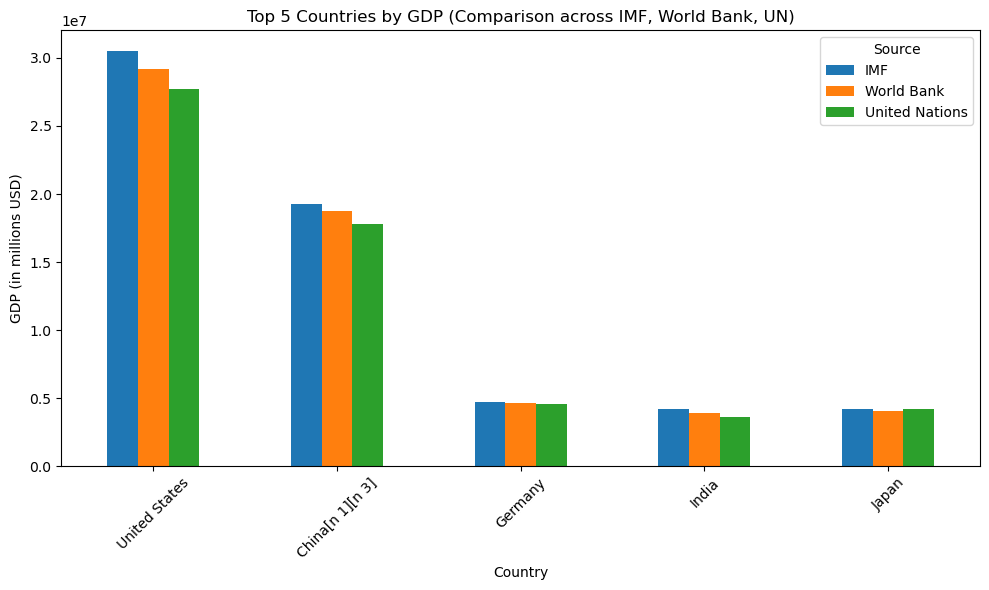

In [15]:
# A grouped bar chart to compare IMF, World Bank, and UN GDP values for the top 5 countries.

import matplotlib.pyplot as plt

# exclude the row where Country == "World"
df_clean = df[df["Country"] != "World"]

# sort by IMF (or another column) and pick top 5
top5 = df_clean.sort_values(by="IMF", ascending=False).head(5)

# set country names as index
top5 = top5.set_index("Country")

# select only numeric columns
top5_values = top5[["IMF", "World Bank", "United Nations"]]

# plot grouped bar chart
ax = top5_values.plot(kind="bar", figsize=(10, 6))

plt.title("Top 5 Countries by GDP (Comparison across IMF, World Bank, UN)")
plt.xlabel("Country")
plt.ylabel("GDP (in millions USD)")
plt.xticks(rotation=45)
plt.legend(title="Source")
plt.tight_layout()
plt.show()